# Import Libraries

In [1]:
from cm_api import *
from cm_config import config
import datetime
from helper_funct import *
from helper_funct1 import *
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
rt = config['refresh_token']
api_token = get_api_token(rt)


# Collect Data

Collect past tracks that were added to Alternative VIBES

In [10]:

data = get_playlist_tracks(api_token, 'spotify', 2085970, 'past', 'us')

In [12]:
#parse data
bucket = []
for track in data:
    track_tuple = (track['isrc'], track['added_at'], track['removed_at'], track['period'], track['name'],
                   track['spotify_artist_names'],
                  track['spotify_popularity'], track['cm_track'], track['cm_artist'], track['track_genre'], 
                  track['release_dates'])
    bucket.append(track_tuple)

df = pd.DataFrame(bucket, columns=['isrc', 'added_at', 'removed_at', 'days_on_playlist', 'title', 'artist', 'spotify_pop', 'cm_track_id','cm_artist_id', 'track_genre', 'release_date'])

#save raw data as csv file

df.to_csv('data/altvibes_past(raw).csv', index_label='label')

# Clean Data

## remove timestamp from datetime columns

In [15]:
#remove timestamp from datetime columns

df['added_at'] = pd.to_datetime(df['added_at']).dt.date
df['removed_at'] = pd.to_datetime(df['removed_at']).dt.date
#since values in the release date column is a list, we need to grab the first item in the list
df['release_date'] = [x[0] for x in df['release_date']]
#now remove time stamp
df['release_date'] = pd.to_datetime(df['release_date']).dt.date

In [19]:
#first item in artist column and id column
df['artist'] = [x[0] for x in df['artist']]

df['cm_artist_id'] = [x[0] for x in df['cm_artist_id']]


## drop duplicate tracks

In [30]:
#drop duplicate tracks
df.drop_duplicates(subset='title',keep='last', inplace=True)

In [39]:
#save cleaned data to new csv

df.to_csv('data/altvibes_past(clean).csv', index_label='index')

# Feature Engineering
Create additional Variables for each record/artist

### Spotify Followers Before/After Playlist Add
    `before_pl_spfollowers` = 7 days before `add_date`
    `after_pl_spfollowers` 7 days after `removed_at`

In [46]:


spfollower_bucket = []
for row in df.iterrows():
    before_date = row[1]['added_at'] - datetime.timedelta(days=7)
    after_date = row[1]['removed_at'] + datetime.timedelta(days=7)

    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'spotify', before_date, after_date, field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        spfollower_bucket.append(tup)
    else:
        tup = (None, None)
        spfollower_bucket.append(tup) 
        
df['before_pl_spfollowers'] = [x[0] for x in spfollower_bucket]
df['after_pl_spfollowers'] = [x[1] for x in spfollower_bucket]

### Twitter Followers Before/After Playlist Add
    `before_pl_twfollowers` = 7 days before `add_date`
    `after_pl_twfollowers` 7 days after `removed_at`

In [48]:
twfollower_bucket = []
for row in df.iterrows():
    before_date = row[1]['added_at'] - datetime.timedelta(days=7)
    after_date = row[1]['removed_at'] + datetime.timedelta(days=7)

    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'twitter', before_date, after_date, field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        twfollower_bucket.append(tup)
    else:
        tup = (None, None)
        twfollower_bucket.append(tup) 
        
df['before_pl_twfollowers'] = [x[0] for x in twfollower_bucket]
df['after_pl_twfollowers'] = [x[1] for x in twfollower_bucket]

### Instagram Followers Before/After Playlist Add
    `before_pl_igfollowers` = 7 days before `add_date`
    `after_pl_igfollowers` 7 days after `removed_at`

In [49]:
igfollower_bucket = []
for row in df.iterrows():
    before_date = row[1]['added_at'] - datetime.timedelta(days=7)
    after_date = row[1]['removed_at'] + datetime.timedelta(days=7)

    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'instagram', before_date, after_date, field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        igfollower_bucket.append(tup)
    else:
        tup = (None, None)
        igfollower_bucket.append(tup) 
        
df['before_pl_igfollowers'] = [x[0] for x in igfollower_bucket]
df['after_pl_igfollowers'] = [x[1] for x in igfollower_bucket]

### Tiktok Followers Before/After Playlist Add
    `before_pl_tkfollowers` = 7 days before `add_date`
    `after_pl_tkfollowers` 7 days after `removed_at`

In [50]:
tkfollower_bucket = []
for row in df.iterrows():
    before_date = row[1]['added_at'] - datetime.timedelta(days=7)
    after_date = row[1]['removed_at'] + datetime.timedelta(days=7)

    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'tiktok', before_date, after_date, field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        tkfollower_bucket.append(tup)
    else:
        tup = (None, None)
        tkfollower_bucket.append(tup) 
        
df['before_pl_tkfollowers'] = [x[0] for x in tkfollower_bucket]
df['after_pl_tkfollowers'] = [x[1] for x in tkfollower_bucket]

## Twitter Status
Boolean value indicating whether or not the artist has a twitter

In [56]:
df['Twitter'] = df['before_pl_twfollowers'].apply(lambda x: True if x > 0 else False)

## Instagram Status
Boolean value indicating whether or not the artist has a Instagram account

In [57]:
df['Instagram'] = df['before_pl_igfollowers'].apply(lambda x: True if x > 0 else False)

## Tiktok Status
Boolean value indicating whether or not the artist has a Tiktok account

In [58]:
df['Tiktok'] = df['before_pl_tkfollowers'].apply(lambda x: True if x > 0 else False)

## Spotify Follower Net Gain

In [62]:
df['Net Follower Gain/Loss(Spotify)'] = df['after_pl_spfollowers'] - df['before_pl_spfollowers']

## Twitter Follower Net Gain

In [63]:
df['Net Follower Gain/Loss(Twitter)'] = df['after_pl_twfollowers'] - df['before_pl_twfollowers']

## Instagram Follower Net Gain/Loss

In [64]:
df['Net Follower Gain/Loss(Instagram)'] = df['after_pl_igfollowers'] - df['before_pl_igfollowers']

## Tiktok Follower Net Gain

In [65]:
df['Net Follower Gain/Loss(Tiktok)'] = df['after_pl_tkfollowers'] - df['before_pl_tkfollowers']

In [66]:
df.to_csv('data/altvibes_past(clean).csv', index_label='index')

In [69]:
#create separate dataframe with no duplicate artists
df1 = df.drop_duplicates(subset='artist', keep='last')
df1.to_csv('data/altvibes_past(clean)V2.csv', index_label='index')

# Analysis

In [2]:
df = pd.read_csv('data/altvibes_past(clean).csv', index_col=0)
df1 = pd.read_csv('data/altvibes_past(clean)V2.csv', index_col=0)

In [53]:
# df.sort_values('added_at', ascending=True).reset_index()

In [54]:
# df.corr()

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   isrc                               89 non-null     object 
 1   added_at                           89 non-null     object 
 2   removed_at                         89 non-null     object 
 3   days_on_playlist                   89 non-null     int64  
 4   title                              89 non-null     object 
 5   artist                             89 non-null     object 
 6   spotify_pop                        22 non-null     float64
 7   cm_track_id                        89 non-null     int64  
 8   cm_artist_id                       89 non-null     int64  
 9   track_genre                        49 non-null     object 
 10  release_date                       89 non-null     object 
 11  before_pl_spfollowers              87 non-null     float64
 

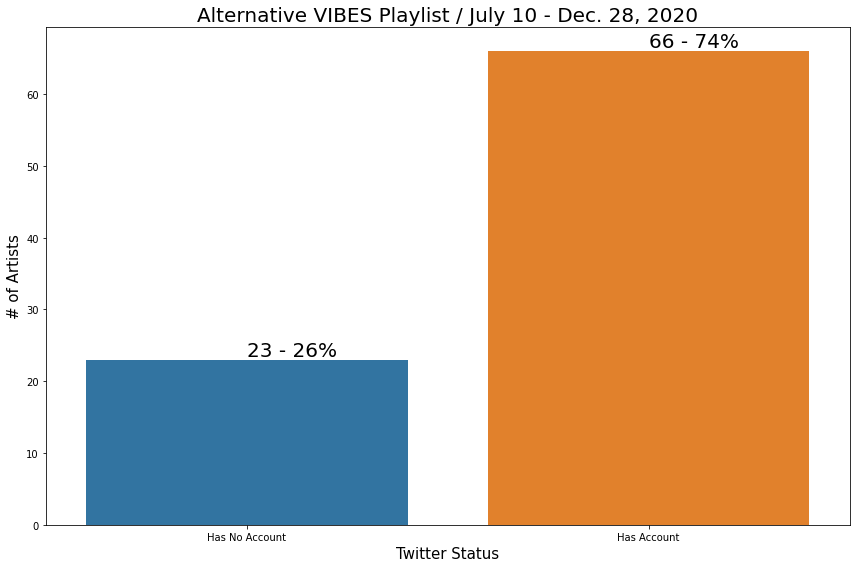

In [124]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df1, x='Twitter', )
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('Twitter Status', fontsize=15)
plt.ylabel('# of Artists', fontsize=15)
ax.set_xticklabels(['Has No Account','Has Account' ])
for p in ax.patches:
    ax.annotate("{} - {}".format(p.get_height(),insert_thousands_commas((p.get_height()/len(df1))*100)+"%"), (p.get_x()+.4, p.get_height()+.5), fontsize=20)

    
plt.tight_layout()
plt.savefig('visuals/twbarplot.jpeg')

plt.show()


/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


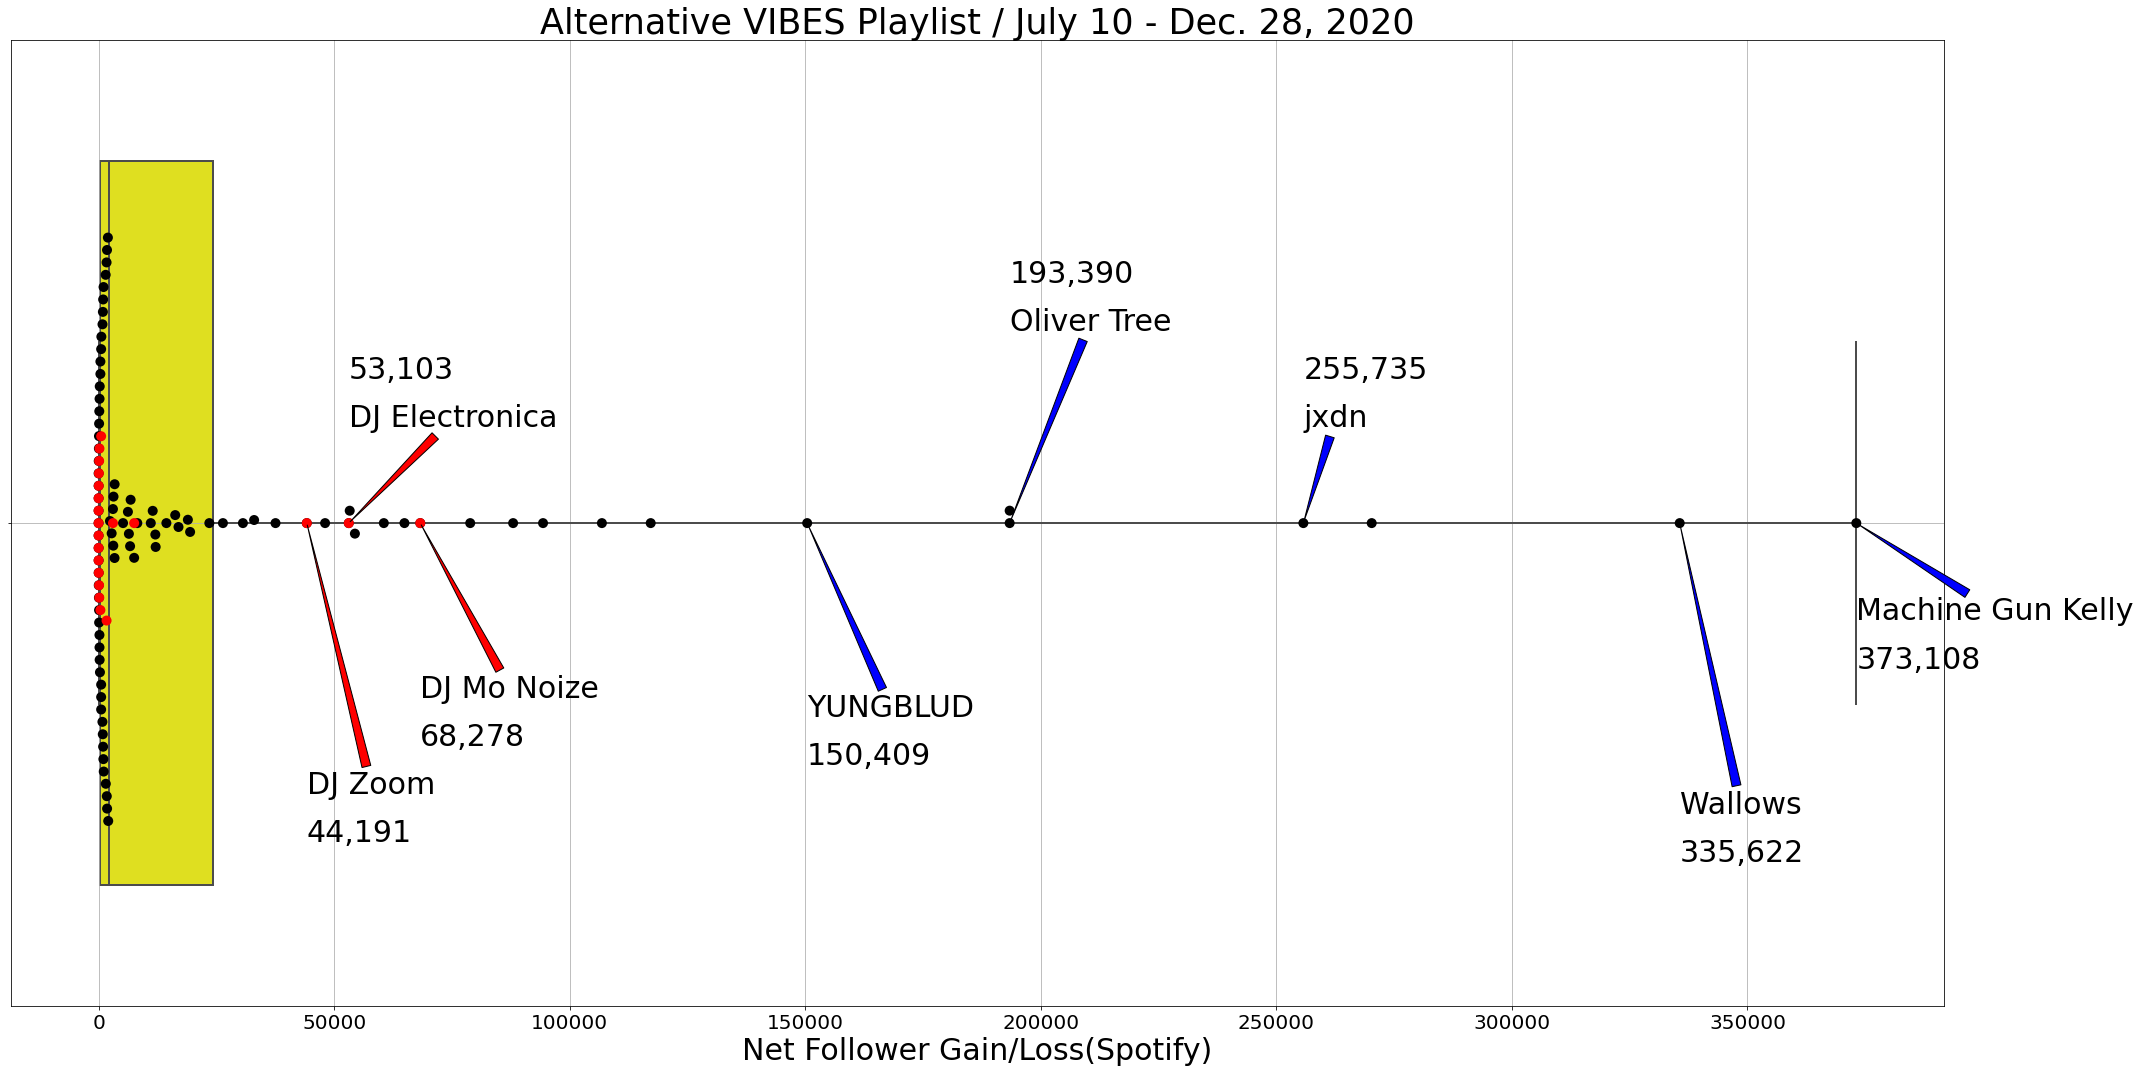

In [12]:
from matplotlib.pyplot import * 

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(df['Net Follower Gain/Loss(Spotify)'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=df,x=df['Net Follower Gain/Loss(Spotify)'], color='black', size=10)
#add markers indicating artists without twitter accounts in red
sns.swarmplot(data=no_tw,x=no_tw['Net Follower Gain/Loss(Spotify)'], color='red', size=10)

#annotate no twitter artists in top 25%
num=0
ya=.18
yb=-.1
for track in no_tw.iterrows():
    if track[1]['Net Follower Gain/Loss(Spotify)'] >= 10000:

        if (num % 2) == 0:
                plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya),
                         arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
                plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya+.05)
                         , fontsize=30)

                num+=1
                ya+=.1
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb-.05)
                     , fontsize=30)


            num+=1
            yb+=-.1

plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=35)
plt.xlabel('Net Follower Gain/Loss(Spotify)', fontsize=30)
plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

num=0
ya=.1
yb=-.1
for track in df1.iterrows():
    if track[1]['Net Follower Gain/Loss(Spotify)'] >= 120000:
        if (num % 2) == 0:
            plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya),
                     arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=30)
            plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya+.05)
                     , fontsize=30)
    
            num+=1
            ya+=.1
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb),
                     arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=30)
            plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb-.05)
                     , fontsize=30)


            num+=1
            yb+=-.1



plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')

plt.tight_layout()
# plt.savefig('visuals/twbarplot.jpeg')

plt.show()

In [132]:
insert_thousands_commas(df1.loc[df1['Twitter'] == True]['Net Follower Gain/Loss(Spotify)'].median())

'4,294'

In [133]:
insert_thousands_commas(df1.loc[df1['Twitter'] == False]['Net Follower Gain/Loss(Spotify)'].median())

'110'

In [5]:
no_tw = df1.loc[df1['Twitter'] == False]

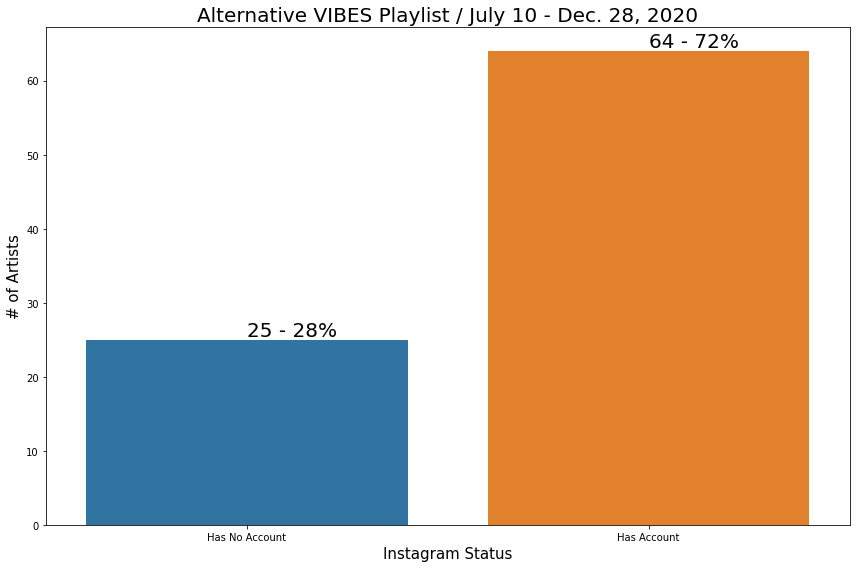

In [126]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df1, x='Instagram', )
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('Instagram Status', fontsize=15)
plt.ylabel('# of Artists', fontsize=15)
ax.set_xticklabels(['Has No Account','Has Account' ])
for p in ax.patches:
    ax.annotate("{} - {}".format(p.get_height(),insert_thousands_commas((p.get_height()/len(df1))*100)+"%"), (p.get_x()+.4, p.get_height()+.5), fontsize=20)

    
plt.tight_layout()
plt.savefig('visuals/igbarplot.png')

plt.show()


In [56]:
insert_thousands_commas(df1.loc[df1['Instagram'] == True]['Net Follower Gain/Loss(Spotify)'].median())

'5,704'

In [57]:
insert_thousands_commas(df1.loc[df1['Instagram'] == False]['Net Follower Gain/Loss(Spotify)'].median())

'110'

In [58]:
no_ig = df1.loc[df1['Instagram'] == False]

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


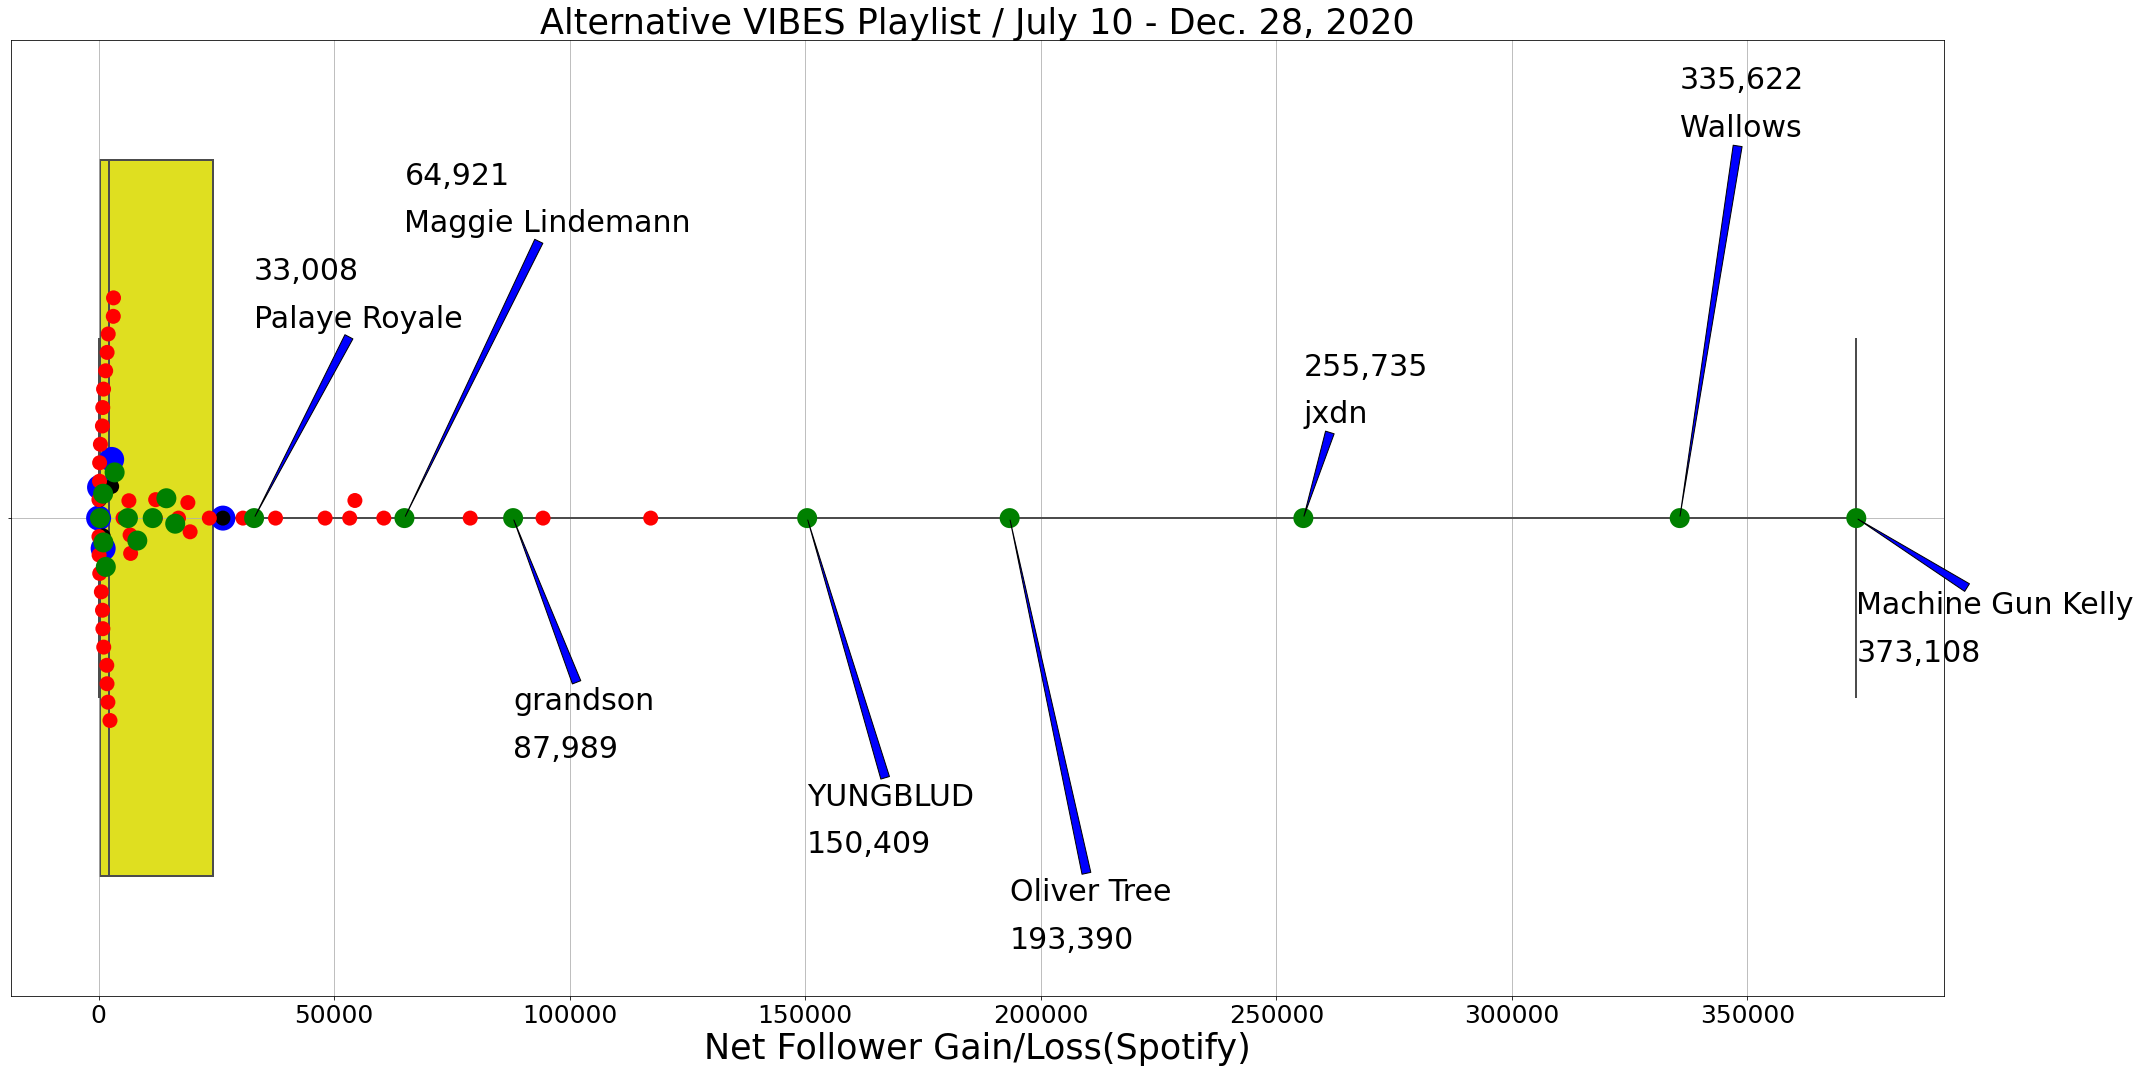

In [53]:
from matplotlib.pyplot import * 

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(df['Net Follower Gain/Loss(Spotify)'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
#markers with just twitter
sns.swarmplot(data=just_twitter,x=just_twitter['Net Follower Gain/Loss(Spotify)'], color='blue', size=25)
#markers with just instagram
sns.swarmplot(data=just_instagram,x=just_twitter['Net Follower Gain/Loss(Spotify)'], color='black', size=15)
#add markers indicating artists without instagram accounts in red
sns.swarmplot(data=two,x=two['Net Follower Gain/Loss(Spotify)'], color='red', size=15)
#add markers indicating artists with all three accounts in green
sns.swarmplot(data=all_three,x=all_three['Net Follower Gain/Loss(Spotify)'], color='green', size=20)


#annotate no twitter artists in top 25%
# num=0
# ya=.18
# yb=-.1
# for track in no_tw.iterrows():
#     if track[1]['Net Follower Gain/Loss(Spotify)'] >= 10000:

#         if (num % 2) == 0:
#                 plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya),
#                          arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#                 plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya+.05)
#                          , fontsize=30)

#                 num+=1
#                 ya+=.1
#         else:
#             plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb),
#                      arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#             plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb-.05)
#                      , fontsize=30)


#             num+=1
#             yb+=-.1

plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=35)
plt.xlabel('Net Follower Gain/Loss(Spotify)', fontsize=35)
plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

num=0
ya=.1
yb=-.1
for track in all_three.iterrows():
    if track[1]['Net Follower Gain/Loss(Spotify)'] >= 24226:
        if (num % 2) == 0:
            plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya),
                     arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=30)
            plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], ya+.05)
                     , fontsize=30)
            
            num+=1
            ya+=.1
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb),
                     arrowprops=dict(facecolor='blue', arrowstyle='wedge'), fontsize=30)
            plt.annotate(insert_thousands_commas(track[1]['Net Follower Gain/Loss(Spotify)']), xy=(track[1]['Net Follower Gain/Loss(Spotify)'], 0),xytext=(track[1]['Net Follower Gain/Loss(Spotify)'], yb-.05)
                     , fontsize=30)

            
            num+=1
            yb+=-.1



plt.tick_params(axis='x', which='major', labelsize=25)
plt.grid(axis='both')

plt.tight_layout()
plt.savefig('visuals/igboxplot.png')

plt.show()

In [19]:
insert_thousands_commas(df1.loc[df1['Instagram'] == True]['Net Follower Gain/Loss(Spotify)'].median())


'5,704'

In [18]:
insert_thousands_commas(df1.loc[df1['Instagram'] == False]['Net Follower Gain/Loss(Spotify)'].median())

'110'

In [54]:
no_ig = df1.loc[df1['Instagram'] == False]
yes_ig = df1.loc[df1['Instagram'] == True]
no_tk = df1.loc[df1['Tiktok'] == False]
yes_tk = df1.loc[df1['Tiktok'] == True]

all_three = df1.loc[(df1['Tiktok'] == True) & (df1['Instagram'] == True) & (df1['Twitter'] == True)]
two = df1.loc[(df1['Tiktok'] == False) & (df1['Instagram'] == True) & (df1['Twitter'] == True)]
just_twitter = df1.loc[(df1['Tiktok'] == False) & (df1['Instagram'] == False) & (df1['Twitter'] == True)]
just_instagram = df1.loc[(df1['Tiktok'] == False) & (df1['Instagram'] == True) & (df1['Twitter'] == False)]

In [71]:
just_instagram[['artist','Net Follower Gain/Loss(Spotify)']]

,artist,Net Follower Gain/Loss(Spotify)
index,,
20,No Love For The Middle Child,1688.0
33,Baby Queen,3045.0
73,Spacey Jane,7545.0


In [68]:
just_twitter[['artist','Net Follower Gain/Loss(Spotify)']]

,artist,Net Follower Gain/Loss(Spotify)
index,,
15,A Certain Ratio,963.0
41,Thelonious Monster,201.0
45,Blair Jollands,2.0
47,Yin Yin,2769.0
62,The Flaming Lips,26389.0


In [56]:
insert_thousands_commas(yes_tk['Net Follower Gain/Loss(Spotify)'].median())

'15,323'

In [57]:
insert_thousands_commas(no_tk['Net Follower Gain/Loss(Spotify)'].median())

'1,688'

In [30]:
get_summary_statistics(df['Net Follower Gain/Loss(Spotify)'].dropna())

Min: -5
Mean: 32,127
Max: 373,108
25th percentile: 354
Median: 2,226
75th percentile: 24,226
Interquartile range (IQR): 23,872


In [63]:
get_summary_statistics(df['before_pl_spfollowers'].dropna())

Min: 1
Mean: 350,714
Max: 4,408,768
25th percentile: 1,519
Median: 18,820
75th percentile: 279,852
Interquartile range (IQR): 278,333


In [62]:
df.keys()

Index(['isrc', 'added_at', 'removed_at', 'days_on_playlist', 'title', 'artist',
       'spotify_pop', 'cm_track_id', 'cm_artist_id', 'track_genre',
       'release_date', 'before_pl_spfollowers', 'after_pl_spfollowers',
       'before_pl_twfollowers', 'after_pl_twfollowers',
       'before_pl_igfollowers', 'after_pl_igfollowers',
       'before_pl_tkfollowers', 'after_pl_tkfollowers', 'Twitter', 'Instagram',
       'Tiktok', 'Net Follower Gain/Loss(Spotify)',
       'Net Follower Gain/Loss(Twitter)', 'Net Follower Gain/Loss(Instagram)',
       'Net Follower Gain/Loss(Tiktok)'],
      dtype='object')

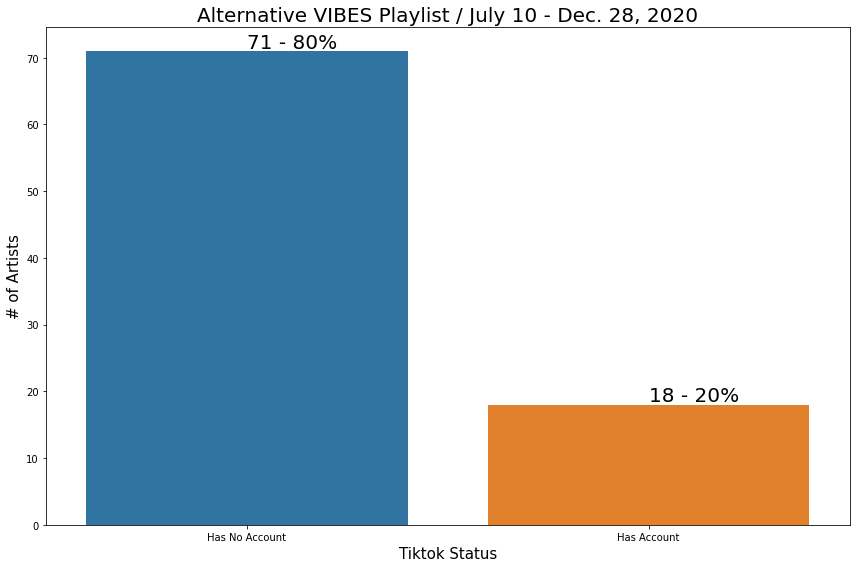

In [128]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df1, x='Tiktok', )
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('Tiktok Status', fontsize=15)
plt.ylabel('# of Artists', fontsize=15)
ax.set_xticklabels(['Has No Account','Has Account' ])
for p in ax.patches:
    ax.annotate("{} - {}".format(p.get_height(),insert_thousands_commas((p.get_height()/len(df1))*100)+"%"), (p.get_x()+.4, p.get_height()+.5), fontsize=20)
    
plt.tight_layout()
plt.savefig('visuals/tkbarplot.png')

plt.show()

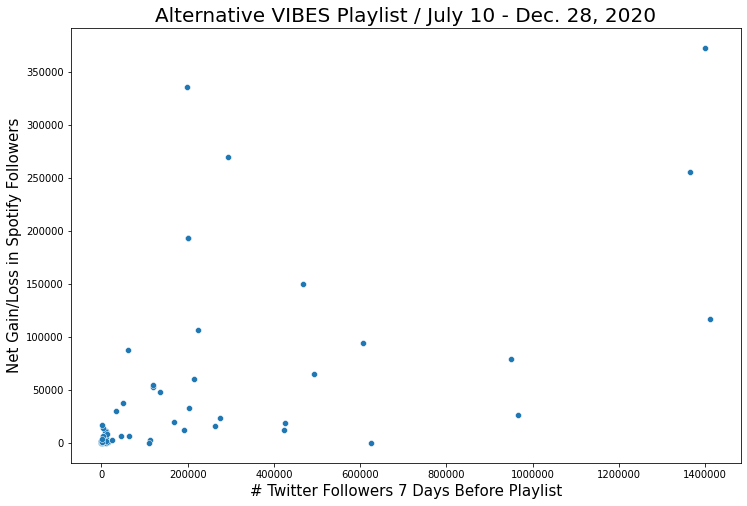

In [121]:
plt.figure(figsize=(12,8))
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('# Twitter Followers 7 Days Before Playlist', fontsize=15)
plt.ylabel('Net Gain/Loss in Spotify Followers', fontsize=15)

plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

sns.scatterplot(data=df,x='before_pl_twfollowers', y='Net Follower Gain/Loss(Spotify)')
plt.savefig('visuals/twscatter.png')

plt.show()


In [132]:
from scipy.stats import pearsonr
df3 = df.dropna(subset=['before_pl_twfollowers', 'Net Follower Gain/Loss(Spotify)'])
pearsonr(df3['before_pl_twfollowers'], df3['Net Follower Gain/Loss(Spotify)'], )

(0.6027036257414145, 3.377596963411197e-08)

In [133]:
df.corr()

,days_on_playlist,spotify_pop,cm_track_id,cm_artist_id,before_pl_spfollowers,after_pl_spfollowers,before_pl_twfollowers,after_pl_twfollowers,before_pl_igfollowers,after_pl_igfollowers,before_pl_tkfollowers,after_pl_tkfollowers,Twitter,Instagram,Tiktok,Net Follower Gain/Loss(Spotify),Net Follower Gain/Loss(Twitter),Net Follower Gain/Loss(Instagram),Net Follower Gain/Loss(Tiktok)
days_on_playlist,1.000000,0.026077,0.031697,-0.065229,0.096894,0.130165,0.353061,0.392323,0.348326,0.369635,0.601344,0.605108,0.249733,0.294377,0.306724,0.424272,0.456609,0.451808,0.544298
spotify_pop,0.026077,1.000000,-0.280441,0.165602,0.371877,0.414074,0.318774,0.340673,0.482905,0.491255,0.296604,0.366184,NaN,0.259892,0.404198,0.606692,0.305172,0.439907,0.601415
cm_track_id,0.031697,-0.280441,1.000000,0.244874,-0.252447,-0.252112,-0.062806,-0.060578,0.036453,0.030284,0.035443,0.013186,-0.230381,-0.257867,-0.086374,-0.130504,-0.020121,-0.019989,-0.070045
cm_artist_id,-0.065229,0.165602,0.244874,1.000000,-0.349504,-0.346166,-0.077499,-0.017812,-0.042475,-0.015256,0.590693,0.572180,-0.709338,-0.584847,-0.207189,-0.148472,0.352824,0.183745,0.433752
before_pl_spfollowers,0.096894,0.371877,-0.252447,-0.349504,1.000000,0.997001,0.750080,0.692480,0.449190,0.428167,0.156605,0.209797,0.284610,0.283208,0.127031,0.498219,0.034763,0.194142,0.378961
after_pl_spfollowers,0.130165,0.414074,-0.252112,-0.346166,0.997001,1.000000,0.770235,0.718137,0.498015,0.479562,0.219299,0.274773,0.290578,0.290160,0.167768,0.563827,0.082457,0.254122,0.444293
before_pl_twfollowers,0.353061,0.318774,-0.062806,-0.077499,0.750080,0.770235,1.000000,0.991426,0.715867,0.725609,0.701968,0.744373,NaN,-0.013468,0.155031,0.602704,0.498816,0.655190,0.808070
after_pl_twfollowers,0.392323,0.340673,-0.060578,-0.017812,0.692480,0.718137,0.991426,1.000000,0.731427,0.749770,0.779484,0.817583,NaN,-0.003749,0.187432,0.634577,0.607793,0.736484,0.856464
before_pl_igfollowers,0.348326,0.482905,0.036453,-0.042475,0.449190,0.498015,0.715867,0.731427,1.000000,0.996979,0.457032,0.507058,0.089625,NaN,0.457239,0.767525,0.518742,0.782877,0.627960
after_pl_igfollowers,0.369635,0.491255,0.030284,-0.015256,0.428167,0.479562,0.725609,0.749770,0.996979,1.000000,0.517011,0.567861,0.087802,NaN,0.461536,0.785429,0.579233,0.828839,0.684290


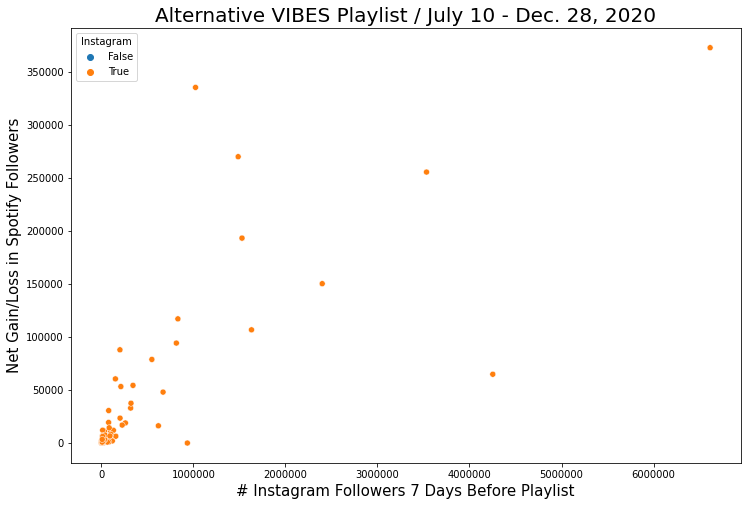

In [120]:
plt.figure(figsize=(12,8))
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('# Instagram Followers 7 Days Before Playlist', fontsize=15)
plt.ylabel('Net Gain/Loss in Spotify Followers', fontsize=15)

plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

sns.scatterplot(data=df,x='before_pl_igfollowers', y='Net Follower Gain/Loss(Spotify)', hue='Instagram', legend="full")
plt.savefig('visuals/igscatter.png')

plt.show()


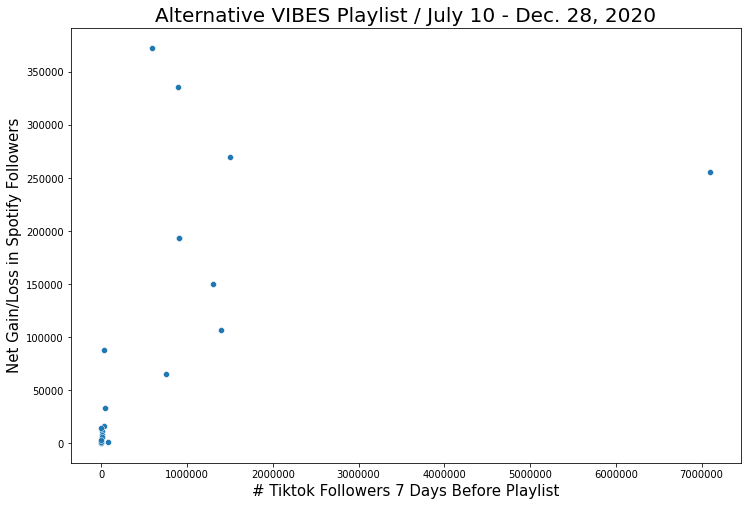

In [32]:
plt.figure(figsize=(12,8))
plt.title('Alternative VIBES Playlist / July 10 - Dec. 28, 2020', fontsize=20)
plt.xlabel('# Tiktok Followers 7 Days Before Playlist', fontsize=15)
plt.ylabel('Net Gain/Loss in Spotify Followers', fontsize=15)

plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style


sns.scatterplot(data=df,x='before_pl_tkfollowers', y='Net Follower Gain/Loss(Spotify)')
plt.savefig('visuals/tkscatter.jpeg')

plt.show()


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   isrc                               98 non-null     object 
 1   added_at                           98 non-null     object 
 2   removed_at                         98 non-null     object 
 3   days_on_playlist                   98 non-null     int64  
 4   title                              98 non-null     object 
 5   artist                             98 non-null     object 
 6   spotify_pop                        24 non-null     float64
 7   cm_track_id                        98 non-null     int64  
 8   cm_artist_id                       98 non-null     int64  
 9   track_genre                        53 non-null     object 
 10  release_date                       98 non-null     object 
 11  before_pl_spfollowers              96 non-null     float64
 

In [89]:
df.sort_values('removed_at', ascending=False)

,isrc,added_at,removed_at,days_on_playlist,title,artist,spotify_pop,cm_track_id,cm_artist_id,track_genre,...,after_pl_igfollowers,before_pl_tkfollowers,after_pl_tkfollowers,Twitter,Instagram,Tiktok,Net Follower Gain/Loss(Spotify),Net Follower Gain/Loss(Twitter),Net Follower Gain/Loss(Instagram),Net Follower Gain/Loss(Tiktok)
index,,,,,,,,,,,,,,,,,,,,,
1,USAT22005095,2020-11-08,2021-02-06,90,Virtual Aerobics,Wallows,NaN,31522611,568354,"indie pop,modern rock,pop",...,1588893.0,1500000.0,1500000.0,True,True,True,270241.0,25754.0,102199.0,0.0
2,QZNWQ2056640,2020-12-24,2021-02-02,40,We Talk,Timo6ka,NaN,32186905,3694325,NaN,...,NaN,NaN,NaN,False,False,False,4.0,NaN,NaN,NaN
18,DEA432000172,2020-12-28,2021-02-02,36,Kirwani - Live 2020,Ragawerk,NaN,32188507,4119413,NaN,...,NaN,NaN,NaN,False,False,False,5.0,NaN,NaN,NaN
96,CAGOO2019865,2020-09-25,2021-02-02,130,Miami Heat,DJ Electronica,NaN,31469126,3771350,NaN,...,NaN,NaN,NaN,False,False,False,53103.0,NaN,NaN,NaN
99,CAGOO2021535,2020-10-28,2021-01-23,87,Funky,DJ Zoom,NaN,31593395,3979233,NaN,...,NaN,NaN,NaN,False,False,False,44191.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,USBQU1900224,2020-07-20,2020-09-24,66,Televised Mind,Fontaines D.C.,NaN,29970141,899906,"chamber psych,english indie rock,irish indie rock",...,94982.0,NaN,NaN,True,True,False,30633.0,4480.0,14879.0,NaN
49,NLQ5B1900002,2020-07-20,2020-09-24,66,Seasons,Vikings in Tibet,NaN,30003282,408572,NaN,...,663.0,NaN,NaN,True,True,False,73.0,-2.0,11.0,NaN
62,USWB12000302,2020-07-20,2020-09-24,66,Dinosaurs on the Mountain,The Flaming Lips,18.0,30061597,75569,"alternative rock,art rock,experimental rock,ga...",...,NaN,NaN,NaN,True,False,False,26389.0,-4071.0,NaN,NaN
